In [3]:
# check the kernel running in the notebook
# !uname -a
# find the variables in the notebook
%whos

Interactive namespace is empty.


In [319]:
import random
import tqdm
import logging
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, KFold, StratifiedKFold
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scipy import interp
from itertools import cycle

In [320]:
def encode_seqCDR(seqCDR):
    encoding_list = []
    for i in range(len(seqCDR)):
        if seqCDR[i] == "*":
            encoding_list.append(np.zeros(5).reshape(1,5))
        elif seqCDR[i] == "_":
            # print("Error: seqCDR contains '_'")
            # encoding_list.append(np.zeros(5).reshape(1,5))
            return np.nan
        else:
            encoding_list.append(af.loc[seqCDR[i]].values.reshape(1,5))
    return np.array(encoding_list).reshape(1,-1)

af = pd.read_csv("~/data/project/pMHC-TCR/library/Atchley_factors.csv")
af.index = af["Amino acid"]
af.drop(columns=["Amino acid"], inplace=True)

In [449]:
class TCR_encode_data(Dataset):
    def __init__(self, file_path):
        df = pd.read_csv(file_path, index_col=0)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))
        # df = df[df["AseqCDR3"].str.contains("_")==False].drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

        # df = df[df["AseqCDR3"].str.contains("_")==False and df["BseqCDR3"].str.contains("_")==False].drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        # drop the rows with duplicate CDR3 sequences
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        df = df.drop_duplicates(subset=["AseqCDR3"], keep="first")
        df = df.drop_duplicates(subset=["BseqCDR3"], keep="first")
        
        # drop the rows with length == max length, which is much longer than the others
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        print(len_map)
        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(
                lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))
        
        # If there is any NaN value, drop the row
        df = df.dropna()
        print(df.shape)

        # concatenate the encoded features
        X_features = torch.zeros((len(df),0))
        for seq in ["AseqCDR3", "BseqCDR3"]:
            X_features = torch.cat((X_features, 
            torch.from_numpy(np.vstack(df[seq].values))), dim=1)

        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values
        
        # discard the duplicate rows, keep the first one
        self.X_features = X_features
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

In [450]:
# df[df["AseqCDR3"].str.contains("_")==False and df["BseqCDR3"].str.contains("_")==False].drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
# sum(df["BseqCDR3"].str.contains("_")==False) / len(df)

In [451]:
class TCR_autoencoder(nn.Module):
    '''
    The autoencoder for TCR sequence.
    For 230221 dataset, the sequnce length is 41 (20+21), and the input size is 41*5,
    the hidden size is 10. And the output size is 41*5. We apply convolutional neural
    network to encode the sequence, and apply deconvolutional neural network to decode
    the sequence. The activation function for convolutional neural network is ReLU,
    because it is a non-linear function, and it is easy to calculate the gradient.
    For the decoder, we use the same activation function as the encoder.

    Param:
        input_size: the input size of the autoencoder
        hidden_size: the hidden size of the autoencoder
        output_size: the output size of the autoencoder, which is the same as the input size
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (batch_size, 5, 49)
            nn.Conv1d(5, 10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 25) based on the formula for conv1d: (W + 2P - K)/S + 1 = (49 + 2*1 - 3)/2 + 1 = 25
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 10, 23), 25 - 2 = 23 

            nn.Conv1d(10, 15, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 12) based on the formula for conv1d: (W + 2P - K)/S + 1 = (23 + 2*1 - 3)/2 + 1 = 12
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 10), 12 - 2 = 10

            nn.Conv1d(15, 20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 5) based on the formula for conv1d: (W + 2P - K)/S + 1 = (10 + 2*1 - 3)/2 + 1 = 5
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 3)

            nn.Conv1d(20, 20 , kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 20, 1) based on the formula for conv1d: (W + 2P - K)/S + 1 = (3 + 2*1 - 5)/2 + 1 = 1
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 1)
            nn.ConvTranspose1d(20, 20, kernel_size=5, stride=2, padding=1),
            # (batch_size, 20, 3), based on the formula for convtranspose1d: (W−1)S−2P+F = (1-1)*2-2*1+5= 3
            nn.LeakyReLU(),

            nn.ConvTranspose1d(20, 15, kernel_size=3, stride=3, padding=1),
            # (batch_size, 15, 5), based on the formula for convtranspose1d: (W−1)S−2P+F = (3-1)*3-2*1+3= 7
            nn.LeakyReLU(),

            nn.ConvTranspose1d(15, 10, kernel_size=7, stride=3, padding=1),
            # (batch_size, 10, 23) based on the formula for convtranspose1d: (W−1)S−2P+F = (7-1)*3-2*1+7= 23
            nn.LeakyReLU(),

            nn.ConvTranspose1d(10, 5, kernel_size=7, stride=2, padding=1),
            # (batch_size, 5, 49) based on the formula for convtranspose1d: (W−1)S−2P+F = (23-1)*2-2*1+7= 49
            nn.LeakyReLU(),
        )

    def forward(self, input):
        # x = torch.tensor(x, dtype=np.float32)
        # x = torch.tensor(x, dtype=torch.float)
        x = input.float()
        encoded = self.encoder(x)
        # print(f"encoding shape: {encoded.shape}")
        encoded = encoded.float()
        output = self.decoder(encoded)
        # print(f"output shape: {output.shape}")
        return encoded, output

In [452]:
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2358, 6)


In [328]:
class TCR_autoencoder(nn.Module):
    '''
    input size: 41*5
    Param:
        input_size: the input size of the autoencoder
        hidden_size: the hidden size of the autoencoder
        output_size: the output size of the autoencoder, which is the same as the input size
    '''
    def __init__(self, kernel_size=3, stride=2, padding=1, batch_size=16):
        super(TCR_autoencoder, self).__init__()
        self.batch_size = batch_size
        self.encoder = nn.Sequential(
            # (batch_size, 5, 46)
            nn.Conv1d(5, 10, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 10, 25) based on the formula for conv1d: (W + 2P - K)/S + 1 = (46 + 2*1 - 3)/2 + 1 = 23
            nn.LeakyReLU(),
            # nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 10, 23), 23 - 2 = 21

            nn.Conv1d(10, 15, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 12) based on the formula for conv1d: (W + 2P - K)/S + 1 = (23 + 2*1 - 3)/2 + 1 = 12
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 10), 12 - 2 = 10

            nn.Conv1d(15, 20, kernel_size=kernel_size, stride=stride, padding=padding),
            # (batch_size, 20, 5) based on the formula for conv1d: (W + 2P - K)/S + 1 = (10 + 2*1 - 3)/2 + 1 = 5
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=3, stride=1),
            # (batch_size, 20, 3)

            nn.Conv1d(20, 20 , kernel_size=5, stride=stride, padding=padding),
            # (batch_size, 20, 1) based on the formula for conv1d: (W + 2P - K)/S + 1 = (3 + 2*1 - 5)/2 + 1 = 1
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            # (batch_size, 20, 1)
            nn.ConvTranspose1d(20, 20, kernel_size=5, stride=2, padding=1),
            # (batch_size, 20, 3), based on the formula for convtranspose1d: (W−1)S−2P+F = (1-1)*2-2*1+5= 3
            nn.LeakyReLU(),

            nn.ConvTranspose1d(20, 15, kernel_size=3, stride=3, padding=1),
            # (batch_size, 15, 5), based on the formula for convtranspose1d: (W−1)S−2P+F = (3-1)*3-2*1+3= 7
            nn.LeakyReLU(),

            nn.ConvTranspose1d(15, 10, kernel_size=7, stride=3, padding=1),
            # (batch_size, 10, 23) based on the formula for convtranspose1d: (W−1)S−2P+F = (7-1)*3-2*1+7= 23
            nn.LeakyReLU(),

            nn.ConvTranspose1d(10, 5, kernel_size=4, stride=2, padding=1),
            # (batch_size, 5, 49) based on the formula for convtranspose1d: (W−1)S−2P+F = (23-1)*2-2*1+4= 46
            nn.LeakyReLU(),
        )

    def forward(self, input):
        # x = torch.tensor(x, dtype=np.float32)
        # x = torch.tensor(x, dtype=torch.float)
        x = input.float()
        encoded = self.encoder(x)
        # print(f"encoding shape: {encoded.shape}")
        encoded = encoded.float()
        output = self.decoder(encoded)
        # print(f"output shape: {output.shape}")
        return encoded, output

Train Epoch: 1 [0/2358 (0%)]	Loss: 1.379062
Train Epoch: 1 [1600/2358 (68%)]	Loss: 1.367565
Train Epoch: 2 [0/2358 (0%)]	Loss: 1.326639
Train Epoch: 2 [1600/2358 (68%)]	Loss: 1.255821
Train Epoch: 3 [0/2358 (0%)]	Loss: 1.224044
Train Epoch: 3 [1600/2358 (68%)]	Loss: 1.221990
Train Epoch: 4 [0/2358 (0%)]	Loss: 1.179031
Train Epoch: 4 [1600/2358 (68%)]	Loss: 1.182141
Train Epoch: 5 [0/2358 (0%)]	Loss: 1.134960
Train Epoch: 5 [1600/2358 (68%)]	Loss: 1.179162
Train Epoch: 6 [0/2358 (0%)]	Loss: 1.239584
Train Epoch: 6 [1600/2358 (68%)]	Loss: 1.097956
Train Epoch: 7 [0/2358 (0%)]	Loss: 1.098996
Train Epoch: 7 [1600/2358 (68%)]	Loss: 1.210337
Train Epoch: 8 [0/2358 (0%)]	Loss: 1.187692
Train Epoch: 8 [1600/2358 (68%)]	Loss: 1.167059
Train Epoch: 9 [0/2358 (0%)]	Loss: 1.048613
Train Epoch: 9 [1600/2358 (68%)]	Loss: 1.111516
Train Epoch: 10 [0/2358 (0%)]	Loss: 1.148146
Train Epoch: 10 [1600/2358 (68%)]	Loss: 1.073526
Train Epoch: 11 [0/2358 (0%)]	Loss: 0.952564
Train Epoch: 11 [1600/2358 (68%)]

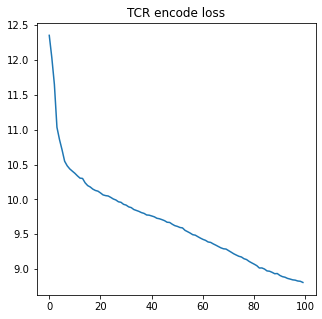

In [453]:
# training the autoencoder to encode the TCR sequence
def train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    # model_accuracy = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, 5, seq_length)
        optimizer.zero_grad()
        _, output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        # TCR_encode_losses.append(loss.item() / model.batch_size)
        # TCR_encode_losses.append(loss.item())
        # sum up batch loss
        batch_loss += loss.item()
        # update the accuracy of the model
        # pred = output.data.max(1, keepdim=True)[1]
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            # print(f"The accuracy of the model is ")
            
    # return batch_loss / len(train_loader.dataset)
    return batch_loss / len(data)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1
seq_length = int(TCRData[0][0].shape[0] / 5)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the autoencoder
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()
train_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)

# plot the loss
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

TCR_encode_losses = []
TCR_accuracy = 0
for epoch in range(1, epochs + 1):
    TCR_encode_loss = train_autoencoder(model, train_loader, optimizer, criterion, epoch, seq_length)
    TCR_encode_losses.append(TCR_encode_loss)
ax.set_title("TCR encode loss")
ax.plot(TCR_encode_losses, label="TCR encode loss")

In [454]:
epochs = 100
batch_size = 16
learning_rate = 1e-3
kernel_size = 3
stride = 2
padding = 1

# load the model
# model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
# model.load_state_dict(torch.load("/DATA/User/wuxinchao/project/pMHC-TCR/ckpt/TCR_autoencoder.pt"))

model.eval()

# encode the TCR sequence
file_path = "~/data/project/data/seqData/20230228.csv"
TCRData = TCR_encode_data(file_path)
# TCR_loader = DataLoader(TCRData, batch_size=batch_size, shuffle=True, drop_last=True)
TCR_encode = torch.zeros((0, 20, 1))
for i in range(len(TCRData)):
    TCR_seq = TCRData[i][0]
    encode_shape = int(TCR_seq.shape[0] / 5)
    TCR_seq = TCR_seq.view(1, 5, encode_shape).float()
    encoded, _ = model(TCR_seq)
    TCR_encode = torch.cat((TCR_encode, encoded), dim=0)

{'AseqCDR3': 25, 'BseqCDR3': 24}
(2358, 6)


In [24]:
# for test, not used
model = TCR_autoencoder(kernel_size=kernel_size, stride=stride, padding=padding, batch_size=batch_size)
kernel_size, stride, padding, seq_length
# pool of size=3, stride=2
# m = nn.MaxPool1d(3, stride=1)
# m = nn.Conv1d(16, 33, 3, stride=2, padding=1)
m = nn.ConvTranspose1d(16, 8, kernel_size=3, stride=2, padding=1)
# m = nn.MaxUnpool1d(kernel_size=3, stride=1)
input = torch.randn(20, 16, 3)
output = m(input)
output.shape
# TCRData[0][0].shape
len(TCRData)
# model(TCRData[0:3][0].float().view(3,5,seq_length))

2492

In [66]:
class LSTM_TCR_encode(nn.Module):
    '''
    LSTM for TCR sequence encoding.
    The input size of LSTM is (batch_size, seq_length, input_size), the output size is (batch_size, seq_length, hidden_size)
    '''
    def __init__(self, seq_length, hidden_size, num_layers, device):
        super(LSTM_TCR_encode, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = device
        self.lstm = nn.LSTM(seq_length, hidden_size, num_layers, batch_first=True, bidirectional=True)

    def forward(self, x):
        x = x.float()
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size).to(self.device)
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        return out

In [9]:
# Train the LSTM model for TCR sequence encoding, this may not be used in the future
# How to use the LSTM model to encode the TCR sequence
# The optimization 
def train_LSTM_TCR_encode(model, train_loader, optimizer, criterion, epoch, seq_length):
    model.train()
    batch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.float()
        data = data.view(batch_size, seq_length, 5)
        optimizer.zero_grad()
        output = model(data)
        # print(output.shape, data.shape)
        loss = criterion(output, data)
        batch_loss += loss.item()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f"Training: {batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%) \
                  Loss: {loss.item():.6f}")
    return batch_loss / len(train_loader.dataset)

# parameters setting
epochs = 100
batch_size = 16
learning_rate = 1e-3
hidden_size = 16
num_layers = 2
seq_length = int(TCRData[0][0].shape[0] / 5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train the LSTM model
model = LSTM_TCR_encode(seq_length, hidden_size, num_layers, device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.MSELoss()

In [364]:
class pMHC_TCRDataset(Dataset):
    '''
    The dataset for the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    Here the input is the TCR sequence, neoantigen sequence, and HLA type.
    The output should be the encoded features of TCR sequence, and the Atchley factor of neoantigen sequence, and the HLA one-hot encoding.
    '''
    def __init__(self, 
                 file_path, 
                 only_CDR3: bool = False, 
                 only_experimental: bool = False, 
                 TCR_encode: str = ["LSTM", "CNN"],
                 encoding_model: nn.Module = None,
                 encoding_size: int = 20,
                 random_state: int = 123) -> None:
        df, HLA_encode, y, feature_size  = self.basic_io(file_path, only_experimental=only_experimental)

        
        # convert from object to tensor
        X_TCR_seq = torch.zeros((len(df), 0))
        for region in ["AseqCDR3", "BseqCDR3"]:
            TCR_seq = df.loc[:, region].values
            TCR_seq_encode = torch.zeros((0, TCR_seq[0].shape[1]))
            for i in range(len(TCR_seq)):
                encoding = torch.from_numpy(TCR_seq[i][0])
                encoding = encoding.reshape(1, -1)
                TCR_seq_encode = torch.cat((TCR_seq_encode, encoding), dim=0)

            X_TCR_seq = torch.cat((TCR_seq_encode, X_TCR_seq), dim=1)
        print(f"X_TCR_seq shape {X_TCR_seq.shape}")
        if TCR_encode == "CNN":
            X_TCR_seq = X_TCR_seq.view(-1, 5, feature_size)
        elif TCR_encode == "LSTM":
            X_TCR_seq = X_TCR_seq.view(-1, 5, feature_size)
        else:
            raise ValueError("The TCR encoding method is not supported yet.")
        
        # encoding model 
        X_features, _ = encoding_model(X_TCR_seq)
        X_features = X_features.view(-1, encoding_size).data

        # add the neoantigen sequence encoding features
        for seq in ["Neo_first3", "Neo_last3"]:
            neo = df.loc[:, seq].values
            neo_encode = torch.zeros((0, neo[0].shape[1]))
            for i in range(len(neo)):
                encoding = torch.from_numpy(neo[i][0])
                encoding = encoding.reshape(1, -1)
                neo_encode = torch.cat((neo_encode, encoding), dim=0)
            X_features = torch.cat((X_features, neo_encode), dim=1)

        X_features = torch.cat((X_features, torch.from_numpy(HLA_encode)), dim=1)


        self.X_features = X_features
        self.y = torch.from_numpy(y)

        # self.X_train, self.X_val, self.y_train, self.y_val = 
    
    def basic_io(self, file_path, only_experimental=True):
        # return the dataframe, contain the 
        df = pd.read_csv(file_path, index_col=0)
        df = df.loc[df["AseqCDR3"].str.len() < 50, :]
        # drop the random generate samples and duplicated 
        df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
        # df = df[df["AseqCDR3"].str.contains("_")==False].drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

        # for chain in ["AseqCDR", "BseqCDR"]:
        #     if only_CDR3:
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        #     else:
        #         df[chain+"_1"] = df[chain].str.split("_").str[0]
        #         df[chain+"_2"] = df[chain].str.split("_").str[1]
        #         df[chain+"_3"] = df[chain].str.split("_").str[2]
        #         df.drop(columns=[chain], inplace=True)
        df["Neo_first3"] = df["NeoAA"].str[:3]
        df["Neo_last3"] = df["NeoAA"].str[-3:]
        df = df.drop(columns=["NeoAA"])

        # encode the Neo_first3, Neo_last3
        for seq in ["Neo_first3", "Neo_last3"]:
            df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

        # encode the CDR3 region
        len_map = {
            "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
            "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
        }
        input_feature_size = sum(len_map.values())

        for chain in ["AseqCDR3", "BseqCDR3"]:
            length = len_map[chain]
            df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
            df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))
        
        # drop the rows with nan
        df = df.dropna()
        if not only_experimental:
            df_ps = df[df["Class"] == "positive"]
            df_ng_ex = df[df["Class"] == "negative"]
            df_ng_em = df.copy()
            df_ng_em = df_ng_em[df_ng_em["Class"] == "positive"]
            df_ng_em["AseqCDR_3"] = df_ng_em["AseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["AseqCDR_3"]) - set(x))))
            df_ng_em["BseqCDR_3"] = df_ng_em["BseqCDR_3"].apply(
                lambda x: random.choice(list(set(df_ng_em["BseqCDR_3"]) - set(x))))
            df_ng = pd.concat([df_ng_em, df_ng_ex], axis=0)
            df_ng.index = range(len(df_ng))
            df = pd.concat([df_ps, df_ng], axis=0)

        X_HLA = df["HLA"].values.reshape(-1, 1)
        HLAencoder = OneHotEncoder()
        X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()
        
        y = df["Class"].apply(lambda x: 1 if x == "positive" else 0)
        y.value_counts().plot.pie(autopct='%.2f')
        return df, X_HLA_encoded, y.values, input_feature_size

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X_features[idx], self.y[idx]

X_TCR_seq shape torch.Size([2492, 245])


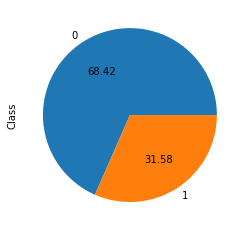

In [365]:
TCRData = pMHC_TCRDataset(file_path, TCR_encode="CNN", only_experimental=True, encoding_model=model)

In [11]:
# TCRData[0][0].shape
# 97.41 / 2.59
# df = pd.read_csv(file_path, index_col=0)
# df = df.loc[df["AseqCDR3"].str.len() < 50, :]

In [30]:
# drop the seq containing _ 
df = df[df["AseqCDR3"].str.contains("_")==False].drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")
df["AseqCDR3"].apply(lambda x:len(x)).max()

23

In [31]:
df["BseqCDR3"].apply(lambda x:len(x)).max()

24

In [48]:
# for val
df = pd.read_csv(file_path, index_col=0)
df = df.loc[df["AseqCDR3"].str.len() < 50, :]

df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

# encode the CDR3 region
len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
for chain in ["AseqCDR3", "BseqCDR3"]:
    length = len_map[chain]
    df[chain] = df[chain].apply(lambda x: x + "*" * (length - len(x)))
    df[chain] = df[chain].apply(lambda x: encode_seqCDR(x))

# drop the rows with nan
df = df.dropna()

X_HLA = df["HLA"].values.reshape(-1, 1)
HLAencoder = OneHotEncoder()
X_HLA_encoded = HLAencoder.fit_transform(X_HLA).toarray()

y = df["Class"].apply(lambda x: 1 if x == "positive" else 0).values

# Prediction model

In [366]:
class prediction_model(nn.Module):
    def __init__(self, 
                 input_size,
                 batch_size=32,) -> None:
        super(prediction_model, self).__init__()
        self.input_size = input_size
        self.batch_size = batch_size
        self.linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2),
        )
        # self.linear_layer = nn.Sequential(
        #     nn.Linear(input_size, 32),
        #     nn.ReLU(),
        #     nn.Linear(32, 16)
        #     nn.ReLU(),
        #     nn.Linear(16, 8),
        #     nn.ReLU(),
        #     nn.Linear(8, 2),
        # )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input):
        input = input.view(self.batch_size, self.input_size)
        # print(f"The model input shape is : {input.shape}")
        output = self.linear_layer(input)
        output = self.softmax(output)
        return output

In [367]:
from torch.utils.data import Subset

class CustomSubset(Subset):
    '''
    A custom subset class that keep the data and targets
    '''
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.X_features = dataset.X_features
        self.y = dataset.y

    def __getitem__(self, idx):
        x, y = self.dataset[self.indices[idx]]
        return x, y
    
    def __len__(self):
        return len(self.indices)

In [368]:
def train(fold, model, device, train_loader, optimizer, epoch, criterion):
    model.train()
    train_loss = 0
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # one-hot encoding the target
        target = target.to(torch.float32).view(-1, 1)
        target = target.to(torch.bool)
        one_hot_target = torch.zeros((target.shape[0], 2))
        one_hot_target[(target==1).squeeze(), 1] = 1
        one_hot_target[(target==0).squeeze(), 0] = 1

        data, one_hot_target = data.to(device), one_hot_target.to(device)
        # data.data extract the item of the torch without the hook on the computation graph
        data = data.view(-1, 20+5*6+2).to(torch.float32)
        output = model(data) # output shape: (batch_size, 2)
        # based on the one-hot target to decide the weights of loss for each class
        # weight = (one_hot_target == torch.tensor([0, 1]).to(device)).sum() / (one_hot_target == torch.tensor([1, 0]).to(device)).sum()
        # weights = torch.tensor([1, 1/weight]).to(device)
        # loss = nn.CrossEntropyLoss(weight=weights)(output, one_hot_target.data)
        loss = criterion(output, one_hot_target.data)
        train_loss += loss.item() / (len(train_loader) * data.size(0))
        # The loss has been weighted, and the loss has already been divided by the batch size
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # get the prediction
        pred = output.argmax(dim=1, keepdim=True) # shape: (batch_size, 1)
        correct += pred.eq(one_hot_target.argmax(dim=1, keepdim=True)).sum().item()

        if batch_idx % 100 == 0:
            print(f"Training stage for Flod {fold} Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader) * data.size(0)} \
                ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
            # print(f"The current output is {output}, and the target is {one_hot_target}")
            # print(f"The weight of the batch is {weights}, \n The output is {output}, \n The one_hot_target is {one_hot_target.data}")
    return train_loss, correct / (len(train_loader) * data.size(0))


def val(fold, model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    pred_history = []
    target_history = []
    
    with torch.no_grad():
        for data, target in val_loader:
            # one-hot encoding the target
            target = target.to(torch.float32).view(-1, 1)
            target = target.to(torch.bool)
            one_hot_target = torch.zeros((target.shape[0], 2))
            one_hot_target[(target==1).squeeze(), 1] = 1
            one_hot_target[(target==0).squeeze(), 0] = 1

            data, one_hot_target = data.to(device), one_hot_target.to(device)
            data = data.view(-1, 20+5*6+2).to(torch.float32).data
            output = model(data) # output shape: (batch_size, 2)
            # get the val loss and prediction
            val_loss += nn.CrossEntropyLoss()(output, one_hot_target.data).item() / (len(val_loader) * data.size(0))
            pred = output.argmax(dim=1, keepdim=True)
            target = one_hot_target.argmax(dim=1, keepdim=True)
            correct += pred.eq(target).sum().item()
            pred_history.extend(output.cpu().detach().numpy()) # shape: (batch_size, 2)
            target_history.extend(one_hot_target.cpu().detach().numpy()) # shape: (batch_size, 2)
            # print(f"The shape of one_hot_target is {target.shape}, and the shape of pred is {pred.shape}")
            # auc += roc_auc_score(target.data.cpu().numpy(), pred.cpu().numpy()) / len(val_loader)
            # fpr, tpr, _ = roc_curve(target.data.cpu().numpy(), pred.cpu().numpy()) 
            # print(f"The fpr is {fpr}, and the tpr is {tpr}")
            # print(f"The auc is {auc}")


    print(f"val set for fold{fold}: Average Loss: \
          {val_loss:.4f}, Accuracy: {correct}/{(len(val_loader) * data.size(0))} \
          ({100. * correct / (len(val_loader) * data.size(0)):.0f}%)")
    # print(f"The length of val_loader is {len(val_loader)}")
    auc = roc_auc_score(target_history, pred_history)
    print(f"The auc of this fold is {auc}")
    return val_loss, correct / (len(val_loader) * data.size(0)), pred_history, target_history

In [444]:
# Parameters
batch_size = 32
input_size = 52
folds = 5
epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

best_vloss = 1e6

def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model = prediction_model(input_size=input_size, batch_size=batch_size).to(device)
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

# Create train dataset and test dataset
# x_train, x_test, y_train, y_test = train_val_split()
training_dataset, testing_dataset = torch.utils.data.random_split(TCRData, lengths=[0.8, 0.2])
training_dataset = CustomSubset(TCRData, training_dataset.indices)
testing_dataset = CustomSubset(TCRData, testing_dataset.indices)

Using cuda:0 for training


In [433]:
# len(training_dataset), len(testing_dataset)
# training_dataset.X_features[training_dataset.indices].shape, training_dataset.y[training_dataset.indices].shape
for fold, (train_idx, val_idx) in enumerate(skf.split(training_dataset.X_features[training_dataset.indices], training_dataset.y[training_dataset.indices])):
    # print(train_idx, val_idx)
    train_dataset = Subset(training_dataset, train_idx)
    val_dataset = Subset(training_dataset, val_idx)
    # print(len(train_dataset), len(val_dataset))
    y_train = [training_dataset.y[i] for i in train_idx]
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weights = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weights[t] for t in y_train]))
    train_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    # print(len(samples_weight))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    # print(train_idx, val_idx)
    val_subsampler = SubsetRandomSampler(val_idx)
    val_dataloader = DataLoader(training_dataset, sampler=val_subsampler ,batch_size=batch_size, drop_last=True)
    break

-------------------Fold 0-------------------
Training stage for Flod 0 Epoch: 1 [0/1568                 (0%)]	Loss: 0.669370
val set for fold0: Average Loss:           0.0189, Accuracy: 263/384           (68%)
The auc of this fold is 0.7606133928290859
Training stage for Flod 0 Epoch: 2 [0/1568                 (0%)]	Loss: 0.568174
val set for fold0: Average Loss:           0.0172, Accuracy: 261/384           (68%)
The auc of this fold is 0.9430582811575243
Training stage for Flod 0 Epoch: 3 [0/1568                 (0%)]	Loss: 0.542504
val set for fold0: Average Loss:           0.0153, Accuracy: 336/384           (88%)
The auc of this fold is 0.9386304909560724
Training stage for Flod 0 Epoch: 4 [0/1568                 (0%)]	Loss: 0.505895
val set for fold0: Average Loss:           0.0141, Accuracy: 335/384           (87%)
The auc of this fold is 0.9501550868486353
Training stage for Flod 0 Epoch: 5 [0/1568                 (0%)]	Loss: 0.361580
val set for fold0: Average Loss:           

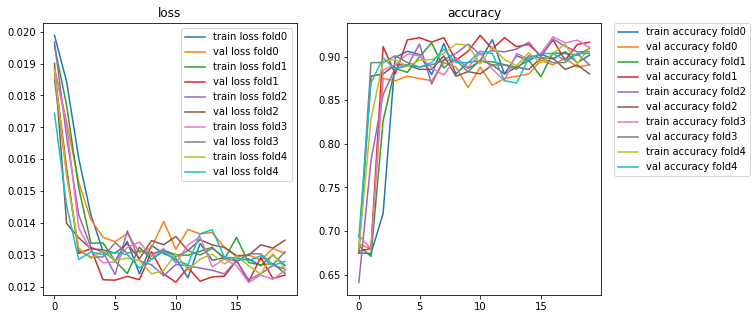

In [445]:
fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title("loss")
ax[1].set_title("accuracy")
# ax[2].set_title("val ROC")


for fold, (train_idx, val_idx) in enumerate(skf.split(training_dataset.X_features[training_dataset.indices], training_dataset.y[training_dataset.indices])):

    print(f"-------------------Fold {fold}-------------------")
    # Randomly select the train and val samples to generate train and val datasets
    # train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    # val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    train_dataset = Subset(training_dataset, train_idx)
    val_dataset = Subset(training_dataset, val_idx)
    
    # weighted random sampler for train datasets
    y_train = [training_dataset.y[i] for i in train_idx]
    class_sample_count = np.array([len(np.where(y_train == t)[0]) for t in np.unique(y_train)])
    weights = 1. / class_sample_count
    samples_weight = torch.from_numpy(np.array([weights[t] for t in y_train]))
    train_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)

    # use all of the valing samples for valing
    # y_val = [TCRData.y[i] for i in test_idx]
    # class_sample_count = np.array([len(np.where(y_test == t)[0]) for t in np.unique(y_test)])
    # weights = 1. / class_sample_count
    # samples_weight = torch.from_numpy(np.array([weights[t] for t in y_test]))
    # test_sampler = WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))
    val_subsampler = SubsetRandomSampler(val_idx)
    val_dataloader = DataLoader(training_dataset, sampler=val_subsampler ,batch_size=batch_size, drop_last=True)

    model.apply(reset_weights)
    train_losses_history = []
    val_losses_history = []
    train_accuracy_history = []
    val_accuracy_history = []
    pred_history = []
    target_history = []
    
    for epoch in range(1, epochs+1):
        train_losses, train_correct = train(fold, model, device, train_dataloader, optimizer, epoch, criterion)
        val_losses, val_correct, pred_history, target_history = val(fold, model, device, val_dataloader)
        if val_losses < best_vloss:
            best_vloss = val_losses
            model_path = f"data/project/data/model_{fold}_{epoch}.pt"
            torch.save(model.state_dict(), model_path)
        train_losses_history.append(train_losses)
        val_losses_history.append(val_losses)
        train_accuracy_history.append(train_correct)
        val_accuracy_history.append(val_correct)

    ax[0].plot(train_losses_history, label=f"train loss fold{fold}")
    ax[0].plot(val_losses_history, label=f"val loss fold{fold}")
    ax[1].plot(train_accuracy_history, label=f"train accuracy fold{fold}")
    ax[1].plot(val_accuracy_history, label=f"val accuracy fold{fold}")

ax[0].legend()
ax[1].legend()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [446]:
# len(test_dataloader)
test_subsampler = SubsetRandomSampler(testing_dataset.indices)
test_dataloader = DataLoader(TCRData, sampler=test_subsampler, batch_size=batch_size, drop_last=True)

test_loss = 0
correct = 0
fpr_history = []
tpr_history = []
target_history = []
pred_history = []

for data, target in test_dataloader:
    target = target.to(torch.float32).view(-1, 1)
    target = target.to(torch.bool)
    one_hot_target = torch.zeros((target.shape[0], 2))
    one_hot_target[(target==1).squeeze(), 1] = 1
    one_hot_target[(target==0).squeeze(), 0] = 1

    data, one_hot_target = data.to(device), one_hot_target.to(device)
    data = data.view(-1, 20+5*6+2).to(torch.float32).data
    output = model(data) # output shape: (batch_size, 2)
    # get the val loss and prediction
    test_loss += nn.CrossEntropyLoss()(output, one_hot_target.data).item() / (len(test_dataloader) * data.size(0))
    pred = output.argmax(dim=1, keepdim=True)
    target = one_hot_target.argmax(dim=1, keepdim=True)
    correct += pred.eq(target).sum().item()
    pred_history.extend(output.cpu().detach().numpy()) # shape: (batch_size, 2)
    target_history.extend(one_hot_target.cpu().detach().numpy()) # shape: (batch_size, 2)

auc = roc_auc_score(target_history, pred_history)

In [437]:
len(pred_history)
# len(target_history)
# len(test_subsampler)
# print(test_subsampler.indices)
# print(val_subsampler.indices)
# check the index of the test dataset is not in the train or val dataset
# print(set(test_subsampler.indices).intersection(set(val_subsampler.indices)))
# print(set(test_subsampler.indices).intersection(set(train_subsampler.indices)))
# test_subsampler.indices

480

/tmp/ipykernel_644673/894575732.py:27: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])


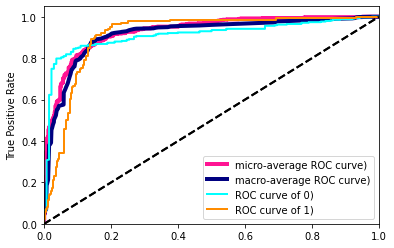

In [447]:
targets = np.zeros((0,2))
for target in target_history:
    targets = np.vstack((targets, target))
# print(targets)

preds = np.zeros((0,2))
for pred in pred_history:
    preds = np.vstack((preds, pred))

fpr_dict = dict()
tpr_dict = dict()
roc_auc_dict = dict()
for i in range(targets.shape[1]):
    fpr_dict[i], tpr_dict[i], _ = roc_curve(list(targets[:,i]), list(preds[:,i]))
    fpr_dict[i] = list(fpr_dict[i])
    tpr_dict[i] = list(tpr_dict[i])
    # roc_auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])

# micro
fpr_dict["micro"], tpr_dict["micro"], _ = roc_curve(targets.ravel(), preds.ravel())
# roc_auc_dict["micro"] = auc(fpr_dict["micro"], tpr_dict["micro"])

# macro
all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(targets.shape[1])]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(targets.shape[1]):
    mean_tpr += interp(all_fpr, fpr_dict[i], tpr_dict[i])
mean_tpr /= targets.shape[1]
fpr_dict["macro"] = all_fpr
tpr_dict["macro"] = mean_tpr
# roc_auc_dict["macro"] = auc(fpr_dict["macro"], tpr_dict["macro"])

plt.figure()
lw=2
plt.plot(fpr_dict["micro"], tpr_dict["micro"],
        label=f'micro-average ROC curve)',
        color='deeppink',  linewidth=4)
plt.plot(fpr_dict["macro"], tpr_dict["macro"],
        label=f'macro-average ROC curve)',
        color='navy',  linewidth=4)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(2), colors):
    plt.plot(fpr_dict[i], tpr_dict[i], color=color, lw=lw, label = f"ROC curve of {i})")
    plt.plot([0,1],[0,1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    # plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [448]:
# val_idx
# test_dataset.indices
# test_dataloader = DataLoader(testing_dataset, batch_size=batch_size, drop_last=True)
# len(test_dataloader)
# testing_dataset.indices
auc

0.9129216459021952

In [379]:
# pred = [i.cpu().detach().numpy() for i in pred_history]
# target = [i.cpu().detach().numpy() for i in target_history]
# len(train_dataset.dataset)
# len(test_dataset.dataset)
# len(TCRData)
# train_idx, test_idx
# test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)
# test_dataset = torch.utils.data.Subset(TCRData, test_idx)
# test_dataloader = DataLoader(TCRData, sampler=test_subsampler ,batch_size=batch_size, drop_last=True)
# train_test_split(TCRData.X_features, TCRData.y, test_size=0.2)[0].shape, train_test_split(TCRData.X_features, TCRData.y, test_size=0.2)[1].shape

# training_dataset, testing_dataset = torch.utils.data.random_split(TCRData, lengths=[0.8, 0.2])
# train_idx, val_idx
# len(train_dataloader) * 32, len(val_dataloader) * 32
# test_subsampler = SubsetRandomSampler(TCRData, testing_dataset.indices)
# test_dataloader = DataLoader(testing_dataset, batch_size=batch_size, drop_last=True)
# model
# len(test_dataloader) * 32

In [298]:

auc

0.2963794955368717

In [305]:
# fpr, tpr, _ = roc_curve()
# auc(list(fpr_dict[0]),list(tpr_dict[0]))
# auc(fpr_dict[0], tpr_dict[0])
# print(preds)
pred_history
# pred_history[-200:], target_history[-200:]
# training_dataset.X_features
# training_dataset.indices
# training_subsampler = SubsetRandomSampler(TCRData, training_dataset.indices)
# training_data = DataLoader(TCRData, sampler=training_subsampler)
# len(TCRData[training_dataset.indices][1])
# torch.utils.data.Subset(TCRData, train_idx)
# train_idx
# training_dataset, testing_dataset = torch.utils.data.random_split(TCRData, lengths=[0.8, 0.2])
# training_dataset = CustomSubset(TCRData, training_dataset.indices)

[array([2.4151566e-04, 9.9975854e-01], dtype=float32),
 array([0.9940837 , 0.00591634], dtype=float32),
 array([0.99388254, 0.00611744], dtype=float32),
 array([0.9938069 , 0.00619304], dtype=float32),
 array([6.750851e-05, 9.999325e-01], dtype=float32),
 array([0.9939016 , 0.00609835], dtype=float32),
 array([0.11002941, 0.88997054], dtype=float32),
 array([0.9939075 , 0.00609257], dtype=float32),
 array([0.99396235, 0.00603769], dtype=float32),
 array([0.10855243, 0.89144754], dtype=float32),
 array([0.9937541 , 0.00624592], dtype=float32),
 array([6.837342e-05, 9.999316e-01], dtype=float32),
 array([2.4353755e-04, 9.9975652e-01], dtype=float32),
 array([0.99379647, 0.0062036 ], dtype=float32),
 array([0.10898533, 0.89101464], dtype=float32),
 array([0.99367005, 0.00632994], dtype=float32),
 array([0.9941544 , 0.00584561], dtype=float32),
 array([0.99404424, 0.00595583], dtype=float32),
 array([0.9940994 , 0.00590067], dtype=float32),
 array([0.9939507 , 0.00604924], dtype=float32),


In [265]:
# len(CustomSubset(TCRData, training_dataset.indices))
# len(training_dataset.X_features[training_dataset.indices])
# len(targets)
# len(train_idx), len(val_idx)
# fpr_history
# target_history
targets

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [0., 1.],
       [1., 0.]])

In [197]:
# len(target_history)
# auc
len(test_dataloader) 

480

In [ ]:
c = torch.randn((32, 92)).to(device)
# # a.shape
d = model(c).to(device)
model.train()
optimizer.zero_grad()
# loss = nn.CrossEntropyLoss()(model(a).to(torch.float32).view(32, 1, 1), torch.ones((32, 1, 1)).to(torch.float32).to(device)) / 32
# loss.to(device)
# loss.backward()
# optimizer.step()
loss_fn = nn.CrossEntropyLoss()
a = torch.randint(0,2,(32,1)) # mask
b = torch.zeros((32,2))
# get the value of b where a is 1
a = a.to(torch.bool)
b[(a==1).squeeze(),1] = 1
b[(a==0).squeeze(),0] = 1
# loss = loss_fn(d, torch.ones((32,2)).to(device))
# loss.backward()
# train_losses_history
# test_losses_history
# test_accuracy_history
# train_accuracy_history
# nn.Softmax(dim=1)(torch.tensor([[1,2,3],[4,5,6]], dtype=torch.float32))
# output = nn.Softmax(dim=1)(torch.tensor([[0.1, 0.9], [0.1, 0.9], [0.1, 0.9]], dtype=torch.float32))
# nn.CrossEntropyLoss()(output, torch.tensor([[0.0, 1.0], [0.0, 1.0], [0.0, 1.0]]))
# (b == torch.tensor([1,0])).sum() / (b == torch.tensor([0,1])).sum()
# b
# 17 / 15

# a = torch.tensor([[1,2,3,4,5],[3,3,4,5,6]], dtype=torch.float32) # print(a.shape) shape: 2, 5
# a.argmax(dim=1, keepdim=True).shape # shape: 2, 1
# a.argmax(dim=1) # shape: 1, 2

TCRData.y.sum() / len(TCRData.y)
# loss.backward()
# torch.zeros((32,2))
# model(torch.randn((32,92)).to(device))
num_dict = {1:2, 2:3, 3:0}
# delete the non-zero key
num_dict.pop(1)
num_dict.pop(2)
# print(num_dict.keys())
# get the key
print(list(num_dict.keys())[0])

0.9318625576199198


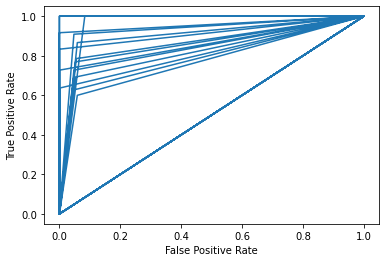

In [100]:
# test_data = test_loader[0]
# test_dataloader.dataset[0]
pred_history = []
target_history = []
fpr_history = []
tpr_history = []
for data, target in test_dataloader:
    model.eval()
    data = data.view(-1, 52).to(torch.float32).data.to(device)
    # print(data.shape)
    one_hot_target = torch.zeros((len(target), 2)).to(device)
    one_hot_target[(target==1).squeeze(),1] = 1
    one_hot_target[(target==0).squeeze(),0] = 1
    pred = model(data)
    pred_history.extend(pred.cpu().detach().numpy()) # batch_size, 2
    target_history.extend(one_hot_target.cpu().detach().numpy()) # batch_size, 2
    fpr, tpr, _ = roc_curve(pred.argmax(dim=1, keepdim=True).cpu().detach().numpy(), 
                            one_hot_target.argmax(dim=1, keepdim=True).cpu().detach().numpy())
    fpr_history.extend(fpr)
    tpr_history.extend(tpr)

auc = roc_auc_score(target_history, pred_history)
# pred_history = [i.argmax() for i in pred_history]
# target_history = [i.argmax() for i in target_history]
# fpr, tpr, _ = roc_curve(target_history, pred_history)
print(auc)
plt.plot(fpr_history, tpr_history)
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
# plt.legend(loc=4)
plt.show()

In [101]:
tpr_history, fpr_history

([0.0,
  0.6,
  1.0,
  0.0,
  0.9166666666666666,
  1.0,
  0.0,
  0.7857142857142857,
  1.0,
  0.0,
  0.7692307692307693,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.6363636363636364,
  1.0,
  0.0,
  0.625,
  1.0,
  0.0,
  0.7272727272727273,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.9090909090909091,
  1.0,
  0.0,
  0.6923076923076923,
  1.0,
  0.0,
  0.8666666666666667,
  1.0,
  0.0,
  1.0,
  1.0,
  0.0,
  0.7272727272727273,
  1.0,
  0.0,
  0.8333333333333334,
  1.0],
 [0.0,
  0.058823529411764705,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.05555555555555555,
  1.0,
  0.0,
  0.05263157894736842,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.041666666666666664,
  1.0,
  0.0,
  0.047619047619047616,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.047619047619047616,
  1.0,
  0.0,
  0.05263157894736842,
  1.0,
  0.0,
  0.058823529411764705,
  1.0,
  0.0,
  0.08333333333333333,
  1.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  1.0])

In [ ]:
# test_data = test_loader[0]
# test_dataloader.dataset[0]
pred_history = []
target_history = []
for data, target in test_dataloader:
    data = data.view(-1, 52).to(torch.float32).data.to(device)
    # print(data.shape)
    one_hot_target = torch.zeros((len(target), 2)).to(device)
    one_hot_target[(target==1).squeeze(),1] = 1
    one_hot_target[(target==0).squeeze(),0] = 1
    pred = model(data)
    pred_history.extend(pred.cpu().detach().numpy()) # batch_size, 2
    target_history.extend(one_hot_target.cpu().detach().numpy()) # batch_size, 2

auc = roc_auc_score(target_history, pred_history)

In [457]:
auc
# target_history[-10:], pred_history[-10:]
# np.argmax(pred_history, axis=1).sum() / len(pred_history)
# test_dataloader.dataset[:][1].sum() / len(test_dataloader.dataset[:][1])

0.3119765947034173

In [409]:
# for data, target in test_dataloader:
#     print(target.shape)

# calculate the auc score of the test model
# for data, target in test_dataloader:
#     data = data.view(-1, 20+5*6+2).to(device)
#     pred = model(data.to(device))
    
#     target = target.to(torch.float32).view(-1, 1)
#     target = target.to(torch.bool)
#     one_hot_target = torch.zeros((len(target), 2))
#     one_hot_target[(target==1).squeeze(),1] = 1
#     one_hot_target[(target==0).squeeze(),0] = 1
#     one_hot_target = one_hot_target.to(device)
#     fpr, tpr, _ = roc_curve(one_hot_target.argmax(dim=1, keepdim=True).cpu().numpy(), pred.cpu().detach().numpy())
#     auc = roc_auc_score(one_hot_target.argmax(dim=1, keepdim=True).cpu().numpy(), pred.cpu().detach().numpy())
#     plt.plot(fpr, tpr, label=f"Fold {fold} AUC: {str(auc)}")
#     plt.ylabel("True Positive Rate")
#     plt.xlabel("False Positive Rate")
#     plt.legend(loc=4)
#     plt.show()

torch.Size([32, 52])


RuntimeError: mat1 and mat2 must have the same dtype

In [408]:
# one_hot_target.argmax(dim=1, keepdim=True).cpu().numpy().shape
# output.cpu().numpy()[:, 1]
# pred.shape
# auc
# plt.plot(fpr, tpr)
# fpr.shape
# tpr.shape
# len(test_dataset)
# one_hot_target = OneHotEncoder().fit_transform(np.array(TCRData.y).reshape(-1,1)).toarray()
# pred = nn.Softmax(dim=1)(model(torch.tensor(test_dataset.X_features, dtype=torch.float32).to(device)))

# auc = roc_auc_score(one_hot_target.argmax(dim=1, keepdim=True).cpu().numpy(), pred.cpu().detach().numpy())
# fpr, tpr, _ = roc_curve(one_hot_target.argmax(dim=1, keepdim=True).cpu().numpy(), pred.cpu().detach().numpy())
# plt.plot(fpr, tpr, label=f"Fold {fold} AUC: {str(auc)}")
# plt.ylabel("True Positive Rate")
# plt.xlabel("False Positive Rate")
# plt.legend(loc=4)
# plt.show()
model

prediction_model(
  (linear_layer): Sequential(
    (0): Linear(in_features=52, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=2, bias=True)
  )
  (softmax): Softmax(dim=1)
)

After encoding, the features are concatanated and used to predict the binding affinity of pMHC-TCR model.

In [19]:
class pMHC_TCR_pred(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        super(pMHC_TCR_pred, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        # use the encoded features to predict the binding affinity through MLP
        self.Linear_layer = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        x = self.Linear_layer(x)
        return x

In [70]:
class LSTM_encode(nn.Module):
    def __init__(self, input_size, seq_length, hidden_size, batch_size, num_layers, device, use_whole_data=False):
        self.input_size = input_size
        self.seq_length = seq_length
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.device = device
        self.use_whole_data = use_whole_data

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

    def forward(self, x):
        x = x.view(self.batch_size, self.seq_length, self.input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        return out[:, -1, :] # return the last hidden state

In [38]:
df = pd.read_csv(file_path, index_col=0)
df["Neo_first3"] = df["NeoAA"].str[:3]
df["Neo_last3"] = df["NeoAA"].str[-3:]
df = df.drop(columns=["NeoAA"])

# encode the Neo_first3, Neo_last3
for seq in ["Neo_first3", "Neo_last3"]:
    df[seq] = df[seq].apply(lambda x: encode_seqCDR(x))

# encode the CDR3 region
df = df.drop_duplicates(subset=["AseqCDR3", "BseqCDR3"], keep="first")

len_map = {
    "AseqCDR3": df["AseqCDR3"].apply(lambda x: len(x)).max(),
    "BseqCDR3": df["BseqCDR3"].apply(lambda x: len(x)).max(),
}
print(len_map)
# drop the rows with length == max length, which is much longer than the others
df = df.loc[df["AseqCDR3"].str.len() < len_map["AseqCDR3"], :]

{'AseqCDR3': 82, 'BseqCDR3': 24}


(array([3.200e+02, 2.288e+03, 2.800e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.100e+01]),
 array([ 5. , 12.6, 20.2, 27.8, 35.4, 43. , 50.6, 58.2, 65.8, 73.4, 81. ]),
 <BarContainer object of 10 artists>)

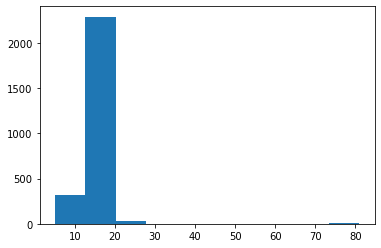

In [43]:
# df["AseqCDR3"].value_counts()
# df["AseqCDR3"].str.len().sort_values(axis=0) # find the longest seq
# df.loc[df["AseqCDR3"].str.len() == 83, "AseqCDR3"]

plt.hist(df["AseqCDR3"].str.len().sort_values(axis=0))
# plt.show()
# df = df.loc[df["AseqCDR3"].str.len() < 83, :]
# df["AseqCDR3"].str.len().sort_values(axis=0)

In [100]:
# len_map
df.to_csv("/home/wuxinchao/data/project/data/seqData/20230228.csv")
# df.loc[df["AseqCDR3"].str.contains("_"),]
# df.shape